# 数据读入模块

In [1]:
import pandas as pd

train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [2]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [3]:
train_data['is_judicial']=[0 if pd.isna(i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial']=[0 if pd.isna(i) else 1 for i in test_data['judicial_reason']]

## 处理NAN

In [4]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [5]:
df_train = delnan(train_data)
df_test = delnan(test_data)


In [6]:
""" for i in range(2, 17):
    print(df_train.iloc[:, i].value_counts()) """


' for i in range(2, 17):\n    print(df_train.iloc[:, i].value_counts()) '

In [7]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25",]

## 转化为one-hot编码（不宜采用）

In [8]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


""" df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)
for i in df_train.columns:
    if i not in df_test.columns:
        df_test[i] = 0
 """

' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [9]:
import pandas as pd
import numpy as np

def cal_woe(df,df_no_label,x_cols,y_col):
    for i in x_cols:
        x_set=pd.unique(df[i])
        for j in x_set:
            woe=np.mean(df[df[i]==j][y_col])
            df[i].replace(j,woe,inplace=True)
            df_no_label[i].replace(j,woe,inplace=True)
    return df,df_no_label

In [10]:
df_train,df_test=cal_woe(df_train,df_test,type_col,"label")

In [11]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col=[i for i in full_col_name if "judicial" in i]

""" for i in judicial_col:
    df_train[i].astype("float")
    df_test[i].astype("float") """

' for i in judicial_col:\n    df_train[i].astype("float")\n    df_test[i].astype("float") '

## 设置哪些x作为模型自变量输入

In [12]:
x_col = basic_col+['is_judicial']+loan_col+query_col+overdue_col
# x_col为模型读入的自变量列名称


""" x_col=['loan2_3_y',
 'loan1_6',
 'loan1_32',
 'loan1_31',
 'basic_7',
 'loan2_4_y',
 'loan2_3',
 'loan1_15',
 'loan2_5_y',
 'loan1_30',
 'loan1_7',
 'loan1_3',
 'query_1',
 'query_7',
 'loan1_17',
 'query_4',
 'loan1_14',
 'basic_1_y',
 'loan1_21',
 'query_1_y'] """

" x_col=['loan2_3_y',\n 'loan1_6',\n 'loan1_32',\n 'loan1_31',\n 'basic_7',\n 'loan2_4_y',\n 'loan2_3',\n 'loan1_15',\n 'loan2_5_y',\n 'loan1_30',\n 'loan1_7',\n 'loan1_3',\n 'query_1',\n 'query_7',\n 'loan1_17',\n 'query_4',\n 'loan1_14',\n 'basic_1_y',\n 'loan1_21',\n 'query_1_y'] "

In [13]:
# df_train.drop(columns=drop_col)

# 训练模型

## 划分测试集训练集

In [14]:
""" from sklearn import model_selection


X = df_train[x_col]
Y = df_train["label"]
seed = 666
test_size = 0.1
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=test_size, random_state=seed) """


' from sklearn import model_selection\n\n\nX = df_train[x_col]\nY = df_train["label"]\nseed = 666\ntest_size = 0.1\nX_train, X_test, y_train, y_test = model_selection.train_test_split(\n    X, Y, test_size=test_size, random_state=seed) '

## 训练模型

## 超参数

In [15]:
N = 1000
num_round = 100
local_test_size=1500

max_depth = [3, 4, 5,6,7,8]
eta = [0.1,0.06]
colsample_bytree = [0.8,0.7, 0.6,0.5]
scale_pos_weight = [1, 3, 6, 10,20, 30]
test_size=[0.3,0.5,0.7]
subsample=[0.7,0.6,0.5,0.4]
par_lambda=[1,1.5,2,3]
alpha=[0,0.2,0.4,0.6,0.8]
min_child_weight=[1,2,3,4,5,6,10]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正地训练集（每次的模型不同）dtrain

In [16]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag=0

num_seq=list(range(len(df_train)))
np.random.shuffle(num_seq)

X_local_test=df_train[x_col].iloc[num_seq[0:local_test_size]]
Y_local_test=df_train["label"].iloc[num_seq[0:local_test_size]]

d_localtest=xgb.DMatrix(X_local_test,label=Y_local_test)

X = df_train[x_col].iloc[num_seq[local_test_size:len(df_train)]]
Y = df_train['label'].iloc[num_seq[local_test_size:len(df_train)]]
x_perd = xgb.DMatrix(df_test[x_col])

for i in range(N):

    #seed = 666
    test_size_this_round=random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        #'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample':random.choice(subsample),
        'alpha':random.choice(alpha),
        'lambda':random.choice(par_lambda),
        'min_child_weight':random.choice(min_child_weight),
        #'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        #"enable_enable_categorical":True,
    }
    
    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=10, verbose_eval=False)
    
    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_local_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])


    temp_dict={"test_auc":loss,"train_auc":train_loss,'local_test_auc':local_test_loss,'test_size':test_size_this_round}
    temp_dict.update(param)

    #info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag==0:
        info_df=pd.DataFrame(temp_dict,index=[i])
        flag=1
    else:
        info_df=pd.concat([info_df,pd.DataFrame(temp_dict,index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss
    

    print(i+1, ":", loss, sep="")
    #print(param)
    #print("-------------------------")
    pred_labels.append([j for j in pred_label])
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")

1:0.6752556079715029
2:0.7233381245683433
3:0.6905042671288475
4:0.7023235080791393
5:0.722393431167016
6:0.7142890985324948
7:0.7153948287910552
8:0.6975327583298923
9:0.7224797358439708
10:0.7060121306874371
11:0.6940156711771853
12:0.7172455318079826
13:0.6904398367012582
14:0.6911575694336015
15:0.7012982838481147
16:0.6999981619336458
17:0.6859614372182781
18:0.7222630628953638
19:0.6968633881515878
20:0.712601163846749
21:0.7338891675025075
22:0.6874823832812306
23:0.6738980253330944
24:0.6895139147476942
25:0.7364482188657737
26:0.6886759649190588
27:0.7077802895779579
28:0.7219576388018548
29:0.7266440239820451
30:0.6943447735449125
31:0.7042906596080397
32:0.6947329809995931
33:0.7338145525880783
34:0.7013148988208544
35:0.6894110162043703
36:0.7155217217170051
37:0.6924402875374385
38:0.6836913670046485
39:0.7136393620422419
40:0.7012824819753958
41:0.7104665569225438
42:0.6630720852017937
43:0.7019153937473878
44:0.7273898750361537
45:0.6785343114925413
46:0.6874739438238583

In [17]:
info_df

,test_auc,train_auc,local_test_auc,test_size,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,subsample,alpha,lambda,min_child_weight,tree_method,gpu_id
0,0.675256,0.821071,0.601661,0.5,3,0.10,0.7,binary:logistic,6,auc,0.6,0.4,2.0,1,gpu_hist,0
1,0.723338,0.924232,0.643060,0.5,4,0.06,0.5,binary:logistic,6,auc,0.7,0.4,2.0,5,gpu_hist,0
2,0.690504,0.808165,0.629107,0.3,3,0.06,0.7,binary:logistic,30,auc,0.4,0.6,2.0,5,gpu_hist,0
3,0.702324,0.875442,0.630924,0.3,4,0.06,0.5,binary:logistic,20,auc,0.4,0.8,2.0,4,gpu_hist,0
4,0.722393,0.839701,0.671039,0.3,4,0.06,0.6,binary:logistic,3,auc,0.4,0.2,2.0,3,gpu_hist,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.698540,0.984660,0.682924,0.3,8,0.06,0.5,binary:logistic,6,auc,0.4,0.0,3.0,3,gpu_hist,0
996,0.684119,0.964291,0.652064,0.7,4,0.10,0.7,binary:logistic,6,auc,0.7,0.6,1.5,1,gpu_hist,0
997,0.739011,0.854002,0.683414,0.3,6,0.06,0.8,binary:logistic,1,auc,0.4,0.0,1.0,10,gpu_hist,0
998,0.729538,0.957793,0.660649,0.5,5,0.06,0.7,binary:logistic,1,auc,0.7,0.6,1.0,1,gpu_hist,0


In [18]:
info_df.to_csv("info.csv",encoding="utf-8",index=False)

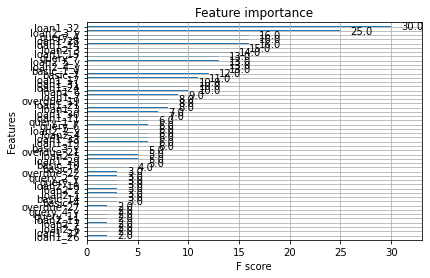

In [19]:
pic=xgb.plot_importance(best_bst,max_num_features=50)
temp=pic.get_ymajorticklabels()
important_x=[str(i).split("\'")[1] for i in temp]
important_x.reverse()

In [20]:
important_x

['loan1_32',
 'loan2_3_y',
 'query_4',
 'loan1_28',
 'loan1_14',
 'loan2_3',
 'loan1_15',
 'query_7',
 'loan2_5_y',
 'loan2_4_y',
 'basic_1_y',
 'basic_7',
 'loan1_17',
 'loan1_31',
 'loan1_24',
 'loan1_6',
 'loan1_7',
 'overdue_19',
 'loan1_21',
 'loan1_3',
 'loan1_30',
 'loan1_11',
 'query_1_y',
 'query_6',
 'loan2_2_y',
 'loan2_4',
 'loan1_33',
 'loan1_19',
 'basic_3_y',
 'overdue_21',
 'loan2_5',
 'loan1_29',
 'basic_10',
 'basic_2',
 'overdue_22',
 'query_2_y',
 'query_1',
 'loan2_10',
 'loan2_2',
 'loan2_1',
 'basic_14',
 'basic_4',
 'overdue_27',
 'query_4_y',
 'query_11',
 'loan2_11',
 'loan2_7',
 'loan2_6',
 'loan1_27',
 'loan1_26']

* basic_7:年龄
* 

# 输出模块

In [21]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in info_df['local_test_auc']])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if True:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(local_test_labels[res_num[i]])
        temp = np.mean(list_temp, axis=0)
        temp_auc = roc_auc_score(Y_local_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i
else:
    n = 100

res_num = res_num[0:n]

final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [list(info_df['local_test_auc'])[i] for i in res_num], sep="")
print("平均之后最大AUC为",max_auc,sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


0 0.738940169305084
1 0.7533119709216127
2 0.755117413553972
3 0.7595533024056627
4 0.7538021904443063
5 0.7523195753025013
6 0.7497249988043426
7 0.7482184705150892
8 0.7474771629441868
9 0.7476923812712228
10 0.7472260748959778
11 0.7478239035821894
12 0.748158687646468
13 0.7463771581615573
14 0.7464847673250753
15 0.7465804199148692
16 0.7454086756898943
17 0.7446673681189917
18 0.7442728011860922
19 0.7431727964034627
20 0.7431369266822899
21 0.7428021426180114
22 0.7422162705055239
23 0.7420967047682816
24 0.7420847481945574
25 0.7418097469989
26 0.7406021330527524
27 0.7404706107417858
28 0.7406858290688221
29 0.7404347410206131
30 0.7399803912190923
31 0.7400401740877134
32 0.7390238653211536
33 0.7387249509780477
34 0.7382706011765269
35 0.7383901669137691
36 0.7382945143239753
37 0.7379836434071452
38 0.7389760390262565
39 0.7385934286670812
40 0.7386412549619781
41 0.7396456071548138
42 0.7392271270744655
43 0.7391075613372233
44 0.7388325601415658
45 0.7389042995839112
46 0

# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？